In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [6]:
# Set the Path for your training and test data ser
PATH = "/content/drive/MyDrive/Bangkit 2022 Capstone Stuff/Capstone_Eye_Diseases"
data_dir_list = os.listdir(PATH)
data_dir_list

['train',
 'ocular_herpes(test_jfif)',
 'conjunctivitis(test_jfif)',
 'glaucoma',
 'ocular_herpes(train_jfif)',
 'conjunctivitis(train_jfif)',
 'test']

In [7]:
# Define the train and test base directories
train_dir = PATH + '/train'
validation_dir = PATH + '/test'

# Directory with training cataract pictures
train_cataract_dir = os.path.join(train_dir, 'cataract')
# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal')
# Directory with training conjunctivitis pictures
train_conjunctivitis_dir = os.path.join(train_dir, 'conjunctivitis')
# Directory with training ocular_herpes pictures
train_ocular_herpes_dir = os.path.join(train_dir, 'ocular_herpes')
# Directory with validation cataract pictures
validation_cataract_dir = os.path.join(validation_dir, 'cataract')
# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')
# Directory with validation conjunctivitis pictures
validation_conjunctivitis_dir = os.path.join(validation_dir, 'conjunctivitis')
# Directory with validation ocular_herpes pictures
validation_ocular_herpes_dir = os.path.join(validation_dir, 'ocular_herpes')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_cataract_dir))} images of cataract for training.\n")
print(f"There are {len(os.listdir(train_normal_dir))} images of normal for training.\n")
print(f"There are {len(os.listdir(train_conjunctivitis_dir))} images of conjunctivitis for training.\n")
print(f"There are {len(os.listdir(train_ocular_herpes_dir))} images of ocular_herpes for training.\n")
print(f"There are {len(os.listdir(validation_cataract_dir))} images of cataract for validation.\n")
print(f"There are {len(os.listdir(validation_normal_dir))} images of normal for validation.\n")
print(f"There are {len(os.listdir(validation_conjunctivitis_dir))} images of conjunctivitis for validation.\n")
print(f"There are {len(os.listdir(validation_ocular_herpes_dir))} images of ocular_herpes for validation.\n")

There are 180 images of cataract for training.

There are 180 images of normal for training.

There are 180 images of conjunctivitis for training.

There are 180 images of ocular_herpes for training.

There are 20 images of cataract for validation.

There are 20 images of normal for validation.

There are 20 images of conjunctivitis for validation.

There are 20 images of ocular_herpes for validation.



Sample cataract image:


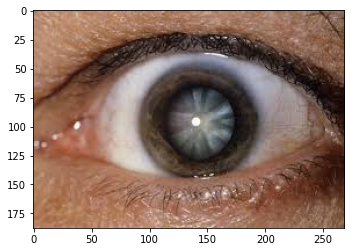


Sample normal image:


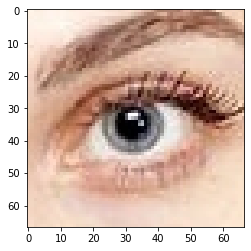


Sample conjunctivitis image:


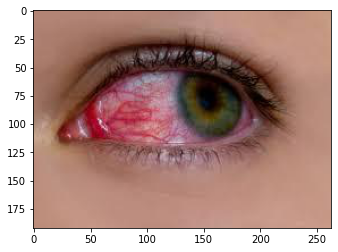


Sample ocular_herpes image:


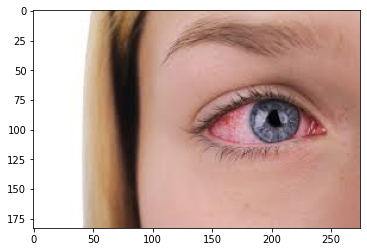

In [8]:
print("Sample cataract image:")
plt.imshow(load_img(f"{os.path.join(train_cataract_dir, os.listdir(train_cataract_dir)[0])}"))
plt.show()

print("\nSample normal image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("\nSample conjunctivitis image:")
plt.imshow(load_img(f"{os.path.join(train_conjunctivitis_dir, os.listdir(train_conjunctivitis_dir)[0])}"))
plt.show()

print("\nSample ocular_herpes image:")
plt.imshow(load_img(f"{os.path.join(train_ocular_herpes_dir, os.listdir(train_ocular_herpes_dir)[0])}"))
plt.show()

In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   horizontal_flip = True)
  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=8, 
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=8, 
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 720 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [11]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-09 06:29:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.164.144, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   299MB/s    in 0.3s    

2022-06-09 06:29:45 (299 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [12]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [13]:
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
      layer.trainable = False

  return pre_trained_model

In [14]:
pre_trained_model = create_pre_trained_model(local_weights_file)
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [15]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [16]:
# Define a Callback class that stops training once accuracy reaches 80%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.80):
      print("\nReached 80% validation accuracy so cancelling training!")
      self.model.stop_training = True

In [17]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output

In [18]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [19]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.5
  x = layers.Dropout(0.5)(x)
  # Add a final softmax layer for classification
  x = layers.Dense(4, activation='softmax')(x)   

  # Create the complete model by using the Model class
  model = Model(pre_trained_model.input, x) 

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [20]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
#total_params = model.count_params()
#num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

#print(f"There are {total_params:,} total parameters in this model.")
#print(f"There are {num_trainable_params:,} trainable parameters in this model.")

In [32]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/50
90/90 [==============================] - 8s 90ms/step - loss: 0.5203 - accuracy: 0.8986 - val_loss: 3.2044 - val_accuracy: 0.7250
Epoch 2/50
90/90 [==============================] - 8s 90ms/step - loss: 0.3727 - accuracy: 0.9264 - val_loss: 3.4160 - val_accuracy: 0.7375
Epoch 3/50
90/90 [==============================] - 8s 88ms/step - loss: 0.3095 - accuracy: 0.9389 - val_loss: 2.8533 - val_accuracy: 0.7500
Epoch 4/50
90/90 [==============================] - 8s 87ms/step - loss: 0.4269 - accuracy: 0.9236 - val_loss: 3.7516 - val_accuracy: 0.7250
Epoch 5/50
90/90 [==============================] - 8s 87ms/step - loss: 0.4320 - accuracy: 0.9208 - val_loss: 3.2203 - val_accuracy: 0.7375
Epoch 6/50
90/90 [==============================] - 8s 86ms/step - loss: 0.5207 - accuracy: 0.8972 - val_loss: 3.3964 - val_accuracy: 0.7250
Epoch 7/50
90/90 [==============================] - 8s 86ms/step - loss: 0.4263 - accuracy: 0.9208 - val_loss: 3.0475 - val_accuracy: 0.7250
Epoch 8/50
90

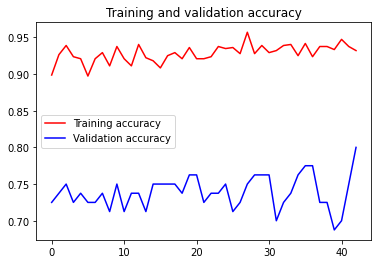

<Figure size 432x288 with 0 Axes>

In [34]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [35]:
validation_generator.class_indices

{'cataract': 0, 'conjunctivitis': 1, 'normal': 2, 'ocular_herpes': 3}

Saving images22.jpg to images22.jpg


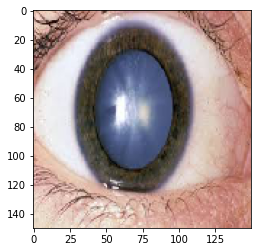

images22.jpg
[[0. 1. 0. 0.]]


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)